In [51]:
import warnings

import numpy as np
import pandas as pd
import torch
from torch import optim
from torch.nn import BatchNorm1d, Dropout, LeakyReLU, Linear, Module, ReLU, Sequential, functional
from tqdm import tqdm
from data_analyse.preprocessing import DataPreprocessor, in_out_to_list
from data_transformer.data_sampler import DataSampler
from data_transformer.data_transformer import DataTransformer
from sklearn.decomposition import PCA
from data_analyse.analyse import DataAnalyzer, display_output
import wandb
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocessing

In [19]:
data = pd.read_csv('data/DataModified.csv', sep=',')

param = data.iloc[:, 1:10]  

cat_cols = ["CONFIG", "T", "EQUIPEMENT", "FREQUENCE"]
num_cols = ["DATA", "DELTA", "MESURE A", "MESURE A REF", "MESURE B"] 

num_param = data[num_cols]
cat_param = data[cat_cols]

param[cat_cols] = data[cat_cols].astype('category')  
data['INPUT'] = data['INPUT'].apply(in_out_to_list)
data['OUTPUT'] = data['OUTPUT'].apply(in_out_to_list)
data['OUTPUT'] = data['OUTPUT'].apply(in_out_to_list)
data = data.join(data['OUTPUT'].apply(pd.Series).add_prefix('OUTPUT_'))
cleaned_data = data.dropna().reset_index(drop=True)
cleaned_output = cleaned_data.iloc[:,11:]


# PCA

In [21]:
pca_full = PCA()
pca_full.fit(cleaned_output)
n_components  = 7
print(f"Information kept {100*sum(pca_full.explained_variance_ratio_[:n_components])}%")
pca = PCA(n_components)
output_pca = pca.fit_transform(cleaned_output)
trainable_data = pd.concat([cleaned_data.iloc[:,1:10], pd.DataFrame(data = output_pca, columns= [f"comp_{i}" for i in np.arange(1,n_components+1)])], axis=1)

Information kept 99.97584921575081%


# Model

In [1]:
def _gumbel_softmax(logits, tau=1, hard=False, eps=1e-10, dim=-1):
    for _ in range(10):
        transformed = functional.gumbel_softmax(logits, tau=tau, hard=hard, eps=eps, dim=dim)
        if not torch.isnan(transformed).any():
            return transformed

class SmallRes(Module):
    def __init__(self, d_input, d_output):
        super().__init__()
        self.layers = Sequential(
            Linear(d_input,d_output),
            BatchNorm1d(d_output),
            LeakyReLU(0.2)
        )
    def forward(self, x):
        out = self.layers(x)
        return torch.cat([x, out], dim = 1)
class Generator(Module):
    def __init__(self, embedding_dim, generator_dim, data_dim):
        super(Generator, self).__init__()
        seq = []
        dim = embedding_dim
        for index in generator_dim:
            seq.append(SmallRes(dim,index))
            dim += index
        seq.append(Dropout(0.3))
        seq.append(Linear(dim, data_dim))
        self.layers = Sequential(*seq)
                
    def forward(self, noise, cond_vec=None):
        if cond_vec is not None:
            x = torch.cat([noise, cond_vec], dim=1)

        else:
            x = noise
            
        for layer in self.layers:
            x = layer(x)
        return x
class Discriminator(Module):
    def __init__(self, input_dim, discriminator_dim, pac=10):
        super().__init__()
        dim = input_dim * pac
        self.pac = pac
        self.pacdim = dim
        seq = []
        for item in list(discriminator_dim):
            seq += [Linear(dim, item), BatchNorm1d(item), LeakyReLU(0.2), Dropout(0.3)]
            dim = item

        seq += [Linear(dim, 1)]
        self.seq = Sequential(*seq)
        
    def calc_gradient_penalty(self, real_data, fake_data, device='cpu', pac=10, lambda_=10):

        batch_size = real_data.size(0) // pac
        alpha = torch.rand(batch_size, 1, 1, device=device)
        alpha = alpha.repeat(1, pac, real_data.size(1)).view(-1, real_data.size(1))
        
        interpolates = alpha * real_data + (1 - alpha) * fake_data
        interpolates.requires_grad_(True)
        
        disc_interpolates = self(interpolates)
        
        ones = torch.ones(disc_interpolates.size(), device=device)
        gradients = torch.autograd.grad(
            outputs=disc_interpolates,
            inputs=interpolates,
            grad_outputs=ones,
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]
        
        gradients = gradients.view(-1, pac * real_data.size(1))
        gradient_norm = gradients.norm(2, dim=1)
        gradient_penalty = lambda_ * ((gradient_norm - 1) ** 2).mean()
        
        return gradient_penalty
    def forward(self, input_):
        assert input_.size()[0] % self.pac == 0
        return self.seq(input_.view(-1, self.pacdim))
class CTGAN():
    def __init__(self,
        embedding_dim=128, generator_dim=(256, 256), discriminator_dim=(256, 256), generator_lr=2e-4,generator_decay=1e-6, discriminator_lr=2e-4, 
        discriminator_decay=1e-6,  discriminator_steps=1, log_frequency=True, pac=10, cuda=True):


        self._embedding_dim = embedding_dim
        self._generator_dim = generator_dim
        self._discriminator_dim = discriminator_dim

        self._generator_lr = generator_lr
        self._generator_decay = generator_decay
        self._discriminator_lr = discriminator_lr
        self._discriminator_decay = discriminator_decay

        self._discriminator_steps = discriminator_steps
        self._log_frequency = log_frequency
        self.pac = pac

        if not cuda or not torch.cuda.is_available():
            device = 'cpu'
        elif isinstance(cuda, str):
            device = cuda
        else:
            device = 'cuda'

        self._device = torch.device(device)

        self._transformer = None
        self._data_sampler = None
        self._generator = None
        self._discriminator = None
        self.loss_values = None
    def _apply_activate(self, data):
        data_t = []
        st = 0
        for column_info in self._transformer.output_info_list:
            for span_info in column_info:
                if span_info.activation_fn == 'tanh':
                    ed = st + span_info.dim
                    data_t.append(torch.tanh(data[:, st:ed]))
                    st = ed
                elif span_info.activation_fn == 'softmax':
                    ed = st + span_info.dim
                    transformed = _gumbel_softmax(data[:, st:ed], tau=0.2)
                    data_t.append(transformed)
                    st = ed
                else:
                    raise ValueError(f'Unexpected activation function {span_info.activation_fn}.')

        return torch.cat(data_t, dim=1)
    def _cond_loss(self, data, c, m):
        loss = []
        st = 0
        st_c = 0
        for column_info in self._transformer.output_info_list:
            for span_info in column_info:
                if len(column_info) != 1 or span_info.activation_fn != 'softmax':
                    st += span_info.dim
                else:
                    ed = st + span_info.dim
                    ed_c = st_c + span_info.dim
                    tmp = functional.cross_entropy(
                        data[:, st:ed], torch.argmax(c[:, st_c:ed_c], dim=1), reduction='none'
                    )
                    loss.append(tmp)
                    st = ed
                    st_c = ed_c

        loss = torch.stack(loss, dim=1)  

        return (loss * m).sum() / data.size()[0]
    def _validate_discrete_columns(self, train_data, discrete_columns):
        if isinstance(train_data, pd.DataFrame):
            invalid_columns = set(discrete_columns) - set(train_data.columns)
        elif isinstance(train_data, np.ndarray):
            invalid_columns = []
            for column in discrete_columns:
                if column < 0 or column >= train_data.shape[1]:
                    invalid_columns.append(column)
        else:
            raise TypeError('``train_data`` should be either pd.DataFrame or np.array.')

        if invalid_columns:
            raise ValueError(f'Invalid columns found: {invalid_columns}')
    def _validate_null_data(self, train_data, discrete_columns):
        if isinstance(train_data, pd.DataFrame):
            continuous_cols = list(set(train_data.columns) - set(discrete_columns))
            any_nulls = train_data[continuous_cols].isna().any().any()
        else:
            continuous_cols = [i for i in range(train_data.shape[1]) if i not in discrete_columns]
            any_nulls = pd.DataFrame(train_data)[continuous_cols].isna().any().any()

        if any_nulls:
            raise ValueError(
                'CTGAN does not support null values in the continuous training data. '
            )
    def fit(self, train_data, discrete_columns=(), epochs=300, batch_size=500,factor=0.5,patience= 10,min_lr=1e-6, track = False, monitor='discriminator_loss'):
        assert batch_size % 2 == 0
        self._validate_discrete_columns(train_data, discrete_columns)
        self._validate_null_data(train_data, discrete_columns)

        self._transformer = DataTransformer()
        self._transformer.fit(train_data, discrete_columns)

        train_data = self._transformer.transform(train_data)

        self._data_sampler = DataSampler(
            train_data, self._transformer.output_info_list, self._log_frequency
        )

        data_dim = self._transformer.output_dimensions

        self._generator = Generator(
            self._embedding_dim + self._data_sampler.dim_cond_vec(), self._generator_dim, data_dim
        ).to(self._device)

        self._discriminator = Discriminator(
            data_dim + self._data_sampler.dim_cond_vec(), self._discriminator_dim, pac=self.pac
        ).to(self._device)

        self.optimizerG = optim.Adam(
            self._generator.parameters(),
            lr=self._generator_lr,
            betas=(0.5, 0.9),
            weight_decay=self._generator_decay,
        )

        self.optimizerD = optim.Adam(
            self._discriminator.parameters(),
            lr=self._discriminator_lr,
            betas=(0.5, 0.9),
            weight_decay=self._discriminator_decay,
        )
        self.scheduler_G = optim.lr_scheduler.ReduceLROnPlateau(self.optimizerG, mode='min', factor=factor, patience=patience,  min_lr=min_lr)
    
        self.scheduler_D = optim.lr_scheduler.ReduceLROnPlateau(self.optimizerD, mode='min', factor=factor, patience=patience, min_lr=min_lr)
        mean = torch.zeros(batch_size, self._embedding_dim, device=self._device)
        std = mean + 1

        best_loss = float('inf')
        early_stop_counter = 0
        early_stop_patience = patience * 2  
        best_model_state = None


        steps_per_epoch = max(len(train_data) // batch_size, 1)
        if track:
            run = wandb.init(project="CTGAN", name="ctgan", config={
                "epochs": epochs,
                "batch_size": batch_size,
                "generator_lr": self._generator_lr,
                "discriminator_lr": self._discriminator_lr,
                "pac": self.pac,
                "data_dim": data_dim,
                "scheduler_patience": patience,
                "scheduler_factor": factor,
                "min_lr": min_lr,
                "early_stop_patience": early_stop_patience
            })
        if track:
            try:
                import wandb
                run = wandb.init(project="CTGAN", name="ctgan", config={
                    "epochs": epochs,
                    "batch_size": batch_size,
                    "generator_lr": self._generator_lr,
                    "discriminator_lr": self._discriminator_lr,
                    "pac": self.pac,
                    "data_dim": data_dim,
                    "scheduler_patience": patience,
                    "scheduler_factor": factor,
                    "min_lr": min_lr,
                    "early_stop_patience": early_stop_patience
                })
                wandb_available = True
            except (ImportError, Exception) as e:
                print(f"Warning: Could not initialize wandb tracking due to: {e}")
                print("Training will continue without tracking.")
                wandb_available = False
        else:
            wandb_available = False
        for i in range(epochs):
            for id_ in range(steps_per_epoch):
                for n in range(self._discriminator_steps):
                    fakez = torch.normal(mean=mean, std=std)

                    condvec = self._data_sampler.sample_condvec(batch_size)
                    if condvec is None:
                        c1, m1, col, opt = None, None, None, None
                        real = self._data_sampler.sample_data(
                            train_data, batch_size, col, opt
                        )
                    else:
                        c1, m1, col, opt = condvec
                        c1 = torch.from_numpy(c1).to(self._device)
                        m1 = torch.from_numpy(m1).to(self._device)
                        fakez = torch.cat([fakez, c1], dim=1)

                        perm = np.arange(batch_size)
                        np.random.shuffle(perm)
                        real = self._data_sampler.sample_data(
                            train_data, batch_size, col[perm], opt[perm]
                        )
                        c2 = c1[perm]

                    fake = self._generator(fakez)
                    fakeact = self._apply_activate(fake)

                    real = torch.from_numpy(real.astype('float32')).to(self._device)

                    if c1 is not None:
                        fake_cat = torch.cat([fakeact, c1], dim=1)
                        real_cat = torch.cat([real, c2], dim=1)
                    else:
                        real_cat = real
                        fake_cat = fakeact

                    y_fake = self._discriminator(fake_cat)
                    y_real = self._discriminator(real_cat)

                    pen = self._discriminator.calc_gradient_penalty(
                        real_cat, fake_cat, self._device, self.pac
                    )
                    loss_d = -(torch.mean(y_real) - torch.mean(y_fake))

                    self.optimizerD.zero_grad(set_to_none=False)
                    pen.backward(retain_graph=True)
                    loss_d.backward()
                    self.optimizerD.step()

                fakez = torch.normal(mean=mean, std=std)
                condvec = self._data_sampler.sample_condvec(batch_size)

                if condvec is None:
                    c1, m1, col, opt = None, None, None, None
                else:
                    c1, m1, col, opt = condvec
                    c1 = torch.from_numpy(c1).to(self._device)
                    m1 = torch.from_numpy(m1).to(self._device)
                    fakez = torch.cat([fakez, c1], dim=1)

                fake = self._generator(fakez)
                fakeact = self._apply_activate(fake)

                if c1 is not None:
                    y_fake = self._discriminator(torch.cat([fakeact, c1], dim=1))
                else:
                    y_fake = self._discriminator(fakeact)

                if condvec is None:
                    cross_entropy = 0
                else:
                    cross_entropy = self._cond_loss(fake, c1, m1)

                loss_g = -torch.mean(y_fake) + cross_entropy

                self.optimizerG.zero_grad(set_to_none=False)
                loss_g.backward()
                self.optimizerG.step()

            generator_loss = loss_g.detach().cpu().item()
            discriminator_loss = loss_d.detach().cpu().item()
            monitored_loss = generator_loss if monitor == 'generator_loss' else discriminator_loss
            self.scheduler_G.step(monitored_loss)
            self.scheduler_D.step(monitored_loss)
            if monitored_loss < best_loss:
                best_loss = monitored_loss
                early_stop_counter = 0
                # Save best model state
                best_model_state = {
                    'generator': self._generator.state_dict(),
                    'discriminator': self._discriminator.state_dict(),
                    'epoch': i,
                    'generator_loss': generator_loss,
                    'discriminator_loss': discriminator_loss
                }
            else:
                early_stop_counter += 1
            if wandb_available:
                current_lr_G = self.optimizerG.param_groups[0]['lr']
                current_lr_D = self.optimizerD.param_groups[0]['lr']
                wandb.log({
                    "epoch": i,
                    "generator_loss": generator_loss,
                    "discriminator_loss": discriminator_loss,
                    "lr_generator": current_lr_G,
                    "lr_discriminator": current_lr_D,
                    "early_stop_counter": early_stop_counter
                })
            if (i + 1) % 5 == 0 or i == 0:
                current_lr_G = self.optimizerG.param_groups[0]['lr']
                current_lr_D = self.optimizerD.param_groups[0]['lr']
                print(f"Epoch [{i+1}/{epochs}], "
                      f"Train - G Loss: {generator_loss:.4f}, D Loss: {discriminator_loss:.4f}, "
                      f"LR - Generator: {current_lr_G:.6f}, Discriminator: {current_lr_D:.6f}, "
                      f"Early stop counter: {early_stop_counter}/{early_stop_patience}")
            if early_stop_counter >= early_stop_patience:
                print(f"Early stopping triggered at epoch {i+1}. No improvement for {early_stop_patience} epochs.")
                # Load the best model state
                if best_model_state is not None:
                    self._generator.load_state_dict(best_model_state['generator'])
                    self._discriminator.load_state_dict(best_model_state['discriminator'])
                    print(f"Loaded best model from epoch {best_model_state['epoch']+1} "
                          f"with {monitor}: {best_model_state[monitor]:.4f}")
                break
        if best_model_state is not None and early_stop_counter < early_stop_patience:
            self._generator.load_state_dict(best_model_state['generator'])
            self._discriminator.load_state_dict(best_model_state['discriminator'])
            print(f"Training completed. Loaded best model from epoch {best_model_state['epoch']+1} "
                  f"with {monitor}: {best_model_state[monitor]:.4f}")
        if wandb_available:
            wandb.finish()
        
    def sample(self, n, condition_column=None, condition_value=None, batch_size= 500):
        if condition_column is not None and condition_value is not None:
            condition_info = self._transformer.convert_column_name_value_to_id(
                condition_column, condition_value
            )
            global_condition_vec = self._data_sampler.generate_cond_from_condition_column_info(
                condition_info, batch_size
            )
        else:
            global_condition_vec = None

        steps = n // batch_size + 1
        data = []
        for i in range(steps):
            mean = torch.zeros(batch_size, self._embedding_dim)
            std = mean + 1
            fakez = torch.normal(mean=mean, std=std).to(self._device)

            if global_condition_vec is not None:
                condvec = global_condition_vec.copy()
            else:
                condvec = self._data_sampler.sample_original_condvec(batch_size)

            if condvec is None:
                pass
            else:
                c1 = condvec
                c1 = torch.from_numpy(c1).to(self._device)
                fakez = torch.cat([fakez, c1], dim=1)

            fake = self._generator(fakez)
            fakeact = self._apply_activate(fake)
            data.append(fakeact.detach().cpu().numpy())

        data = np.concatenate(data, axis=0)
        data = data[:n]

        return self._transformer.inverse_transform(data)

    def set_device(self, device):
        self._device = device
        if self._generator is not None:
            self._generator.to(self._device)
    def save(self, path):
        if self._generator is None or self._discriminator is None:
            raise RuntimeError("Model not trained. Call fit() first.")
        checkpoint = {
            'generator': self._generator.state_dict(),
            'discriminator': self._discriminator.state_dict(),
            'generator_optimizer': self.optimizerG.state_dict(),
            'discriminator_optimizer': self.optimizerD.state_dict(),
            'transformer': self._transformer,
            'pac': self.pac
        }    
        torch.save(checkpoint, path)

NameError: name 'Module' is not defined

# Train

In [29]:
device = torch.device('cuda')
torch.cuda.init()  # Initialize CUDA

In [41]:
ctgan = CTGAN()
ctgan.fit(train_data= trainable_data, discrete_columns= cat_cols)

Epoch [1/300], Train - G Loss: 1.6361, D Loss: -0.0328, LR - Generator: 0.000200, Discriminator: 0.000200, Early stop counter: 0/20
Epoch [5/300], Train - G Loss: 1.4565, D Loss: 0.0373, LR - Generator: 0.000200, Discriminator: 0.000200, Early stop counter: 4/20
Epoch [10/300], Train - G Loss: 1.1875, D Loss: -0.0839, LR - Generator: 0.000200, Discriminator: 0.000200, Early stop counter: 0/20
Epoch [15/300], Train - G Loss: 0.9640, D Loss: -0.0241, LR - Generator: 0.000200, Discriminator: 0.000200, Early stop counter: 5/20
Epoch [20/300], Train - G Loss: 0.6282, D Loss: 0.0755, LR - Generator: 0.000200, Discriminator: 0.000200, Early stop counter: 10/20
Epoch [25/300], Train - G Loss: 0.4045, D Loss: 0.0023, LR - Generator: 0.000100, Discriminator: 0.000100, Early stop counter: 15/20
Epoch [30/300], Train - G Loss: 0.3914, D Loss: 0.0023, LR - Generator: 0.000100, Discriminator: 0.000100, Early stop counter: 20/20
Early stopping triggered at epoch 30. No improvement for 20 epochs.
Load

In [55]:
synthetic_data = ctgan.sample(n=1000)

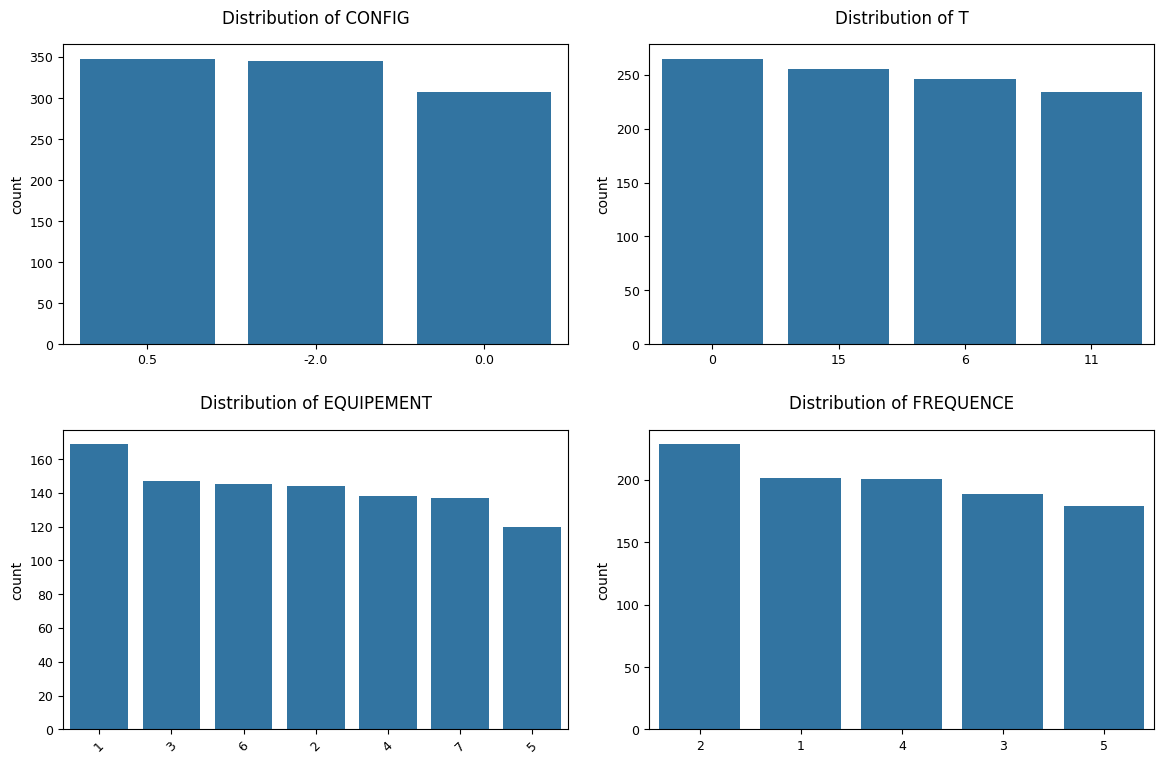

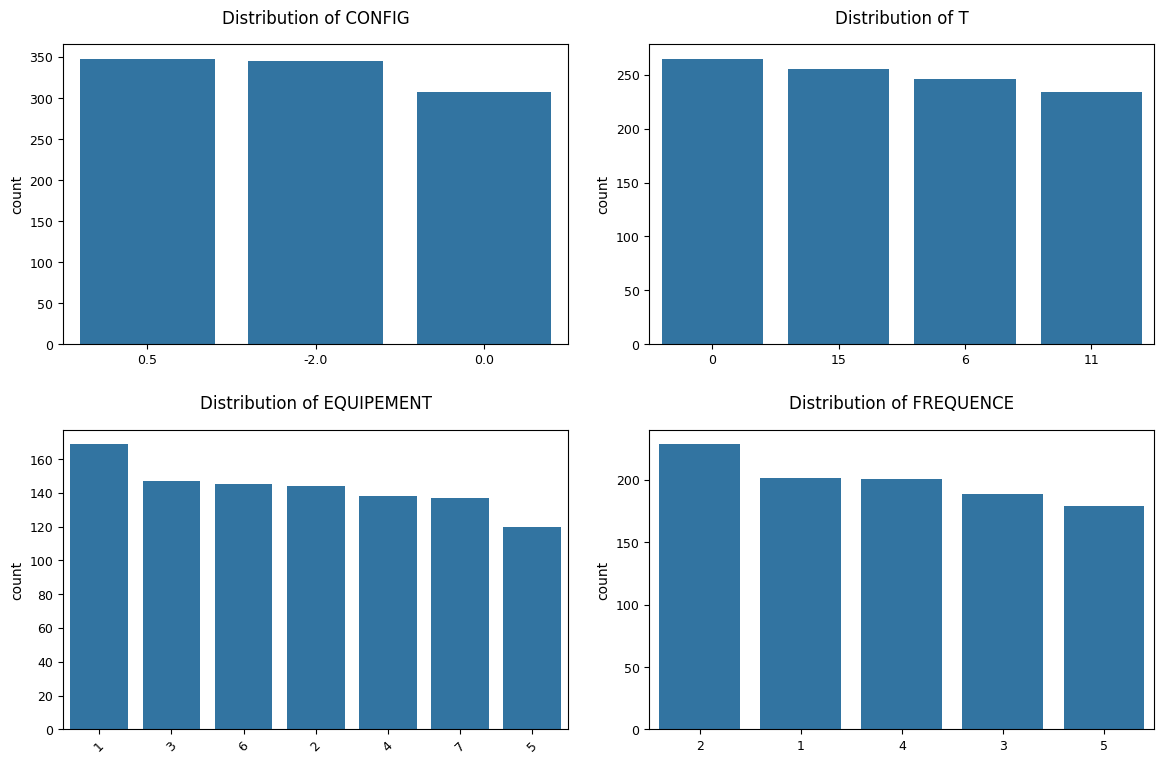

In [57]:
analyzer1 = DataAnalyzer(synthetic_data, numeric_columns = num_cols, categorical_columns= cat_cols)
analyzer1.plot_distributions_cat()

In [61]:
a = pca.inverse_transform([synthetic_data.iloc[:100,9:]])

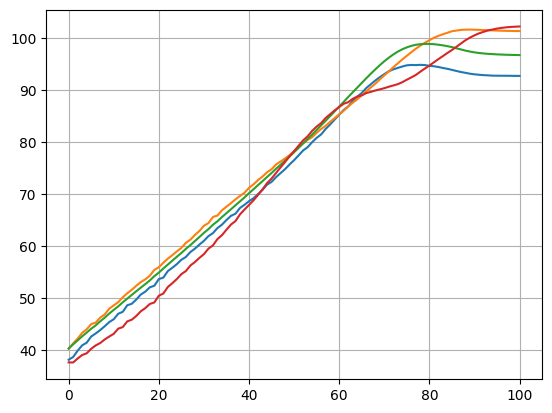

In [65]:
plt.plot(a[0][0])
plt.plot(a[0][10])
plt.plot(a[0][20])
plt.plot(a[0][50])
plt.grid()

In [6]:
a = pd.DataFrame({
    'A': [1,2,1,2,1,2,1,3,3,2,2,2,1,1,1], 
    'B': ['z','z','zz', 'z', 'z','z','z','zz', 'z', 'z','z','z','zz', 'z', 'z'], 
    'C': [0.99404096, 0.58273721, 0.21701061, 0.1175965,  0.68291119, 0.62865904, 
          0.68754258, 0.51539969, 0.70036077, 0.94512348, 0.13780938, 0.04576671,
          0.0784216, 0.19138225, 0.78545446]
})

# Create a copy of the dataframe to preserve original
df = a.copy()

# Identify categorical columns
categorical_columns = ['A', 'B']
numeric_columns = ['C']
ctgan = CTGAN(generator_lr= 00.02, discriminator_lr=0.02)
ctgan.fit(a, categorical_columns,epochs= 100)

C:\Users\anhqu\anaconda3\envs\torchenv\Lib\site-packages\torch\autograd\graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/100], Train - G Loss: 1.0960, D Loss: -0.0156, LR - Generator: 0.020000, Discriminator: 0.020000, Early stop counter: 0/20
Epoch [5/100], Train - G Loss: 0.6899, D Loss: 0.0461, LR - Generator: 0.020000, Discriminator: 0.020000, Early stop counter: 4/20
Epoch [10/100], Train - G Loss: 0.4611, D Loss: -0.1128, LR - Generator: 0.020000, Discriminator: 0.020000, Early stop counter: 0/20
Epoch [15/100], Train - G Loss: 0.1214, D Loss: 0.1288, LR - Generator: 0.020000, Discriminator: 0.020000, Early stop counter: 5/20
Epoch [20/100], Train - G Loss: -0.0452, D Loss: -0.0063, LR - Generator: 0.020000, Discriminator: 0.020000, Early stop counter: 10/20
Epoch [25/100], Train - G Loss: -0.0028, D Loss: -0.0103, LR - Generator: 0.010000, Discriminator: 0.010000, Early stop counter: 15/20
Epoch [30/100], Train - G Loss: 0.0474, D Loss: -0.1048, LR - Generator: 0.010000, Discriminator: 0.010000, Early stop counter: 20/20
Early stopping triggered at epoch 30. No improvement for 20 epochs.


In [47]:
ctgan.sample(n=10)

,DATA,CONFIG,T,EQUIPEMENT,DELTA,MESURE A,MESURE A REF,MESURE B,FREQUENCE,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7
0,225,0.5,11,1,114.919554,-0.150044,-0.903487,-2.276956,3,39.356957,5.239864,-12.179924,3.786869,0.645461,-0.055820,0.870330
1,69,0.5,11,3,-4.161242,0.071134,-0.255725,-1.519427,2,22.244812,13.634840,-9.366882,2.425854,2.036958,0.859537,1.716037
2,208,-2.0,11,7,-168.998449,-3.614764,-0.490950,2.392203,3,-16.474374,-13.607250,3.992089,4.304245,-0.116641,-0.053325,-1.734803
3,190,-2.0,15,5,-59.389944,-2.846072,0.026597,3.091171,3,13.445988,-4.045069,-1.670541,0.506973,0.473266,-0.767986,0.905074
4,196,0.0,6,5,104.814829,-0.602329,-0.065779,2.243605,5,3.651934,18.639861,27.099002,0.395829,-0.091630,4.723548,1.421151
5,206,0.5,6,4,74.249826,-2.272369,-0.719842,1.969881,4,11.596593,-25.632416,-10.429065,-0.704502,-0.267946,1.136374,0.306769
6,93,0.5,0,4,87.307994,-0.142761,-0.091284,2.150253,5,20.391496,0.492896,9.260749,-2.563305,-0.150654,1.644155,2.650829
7,122,0.0,15,7,-121.248225,-11.155745,-0.644687,0.623194,3,31.786976,-25.969888,5.605746,-3.830816,-0.078659,2.471127,-0.487526
8,132,-2.0,0,4,64.984594,-1.050692,-0.901869,-0.801008,3,19.681071,-7.756419,-0.017955,1.009871,0.305733,-0.246311,-0.994836
9,276,-2.0,0,7,-101.806774,0.054265,0.117949,3.207595,5,-13.227379,-40.828095,0.934824,-3.008096,0.243799,0.584866,-0.097535


In [51]:
ctg.fit(a, categorical_columns,epochs= 100)

Epoch [1/100], Train - G Loss: 1.0768, D Loss: -0.0457, LR - Generator: 0.000200, Discriminator: 0.000200
Epoch [10/100], Train - G Loss: 1.0926, D Loss: -0.0510, LR - Generator: 0.000200, Discriminator: 0.000200
Epoch [20/100], Train - G Loss: 0.9101, D Loss: 0.0605, LR - Generator: 0.000200, Discriminator: 0.000200
Epoch [30/100], Train - G Loss: 0.8643, D Loss: -0.0710, LR - Generator: 0.000200, Discriminator: 0.000200
Epoch [40/100], Train - G Loss: 0.8702, D Loss: 0.1008, LR - Generator: 0.000200, Discriminator: 0.000200
Epoch [50/100], Train - G Loss: 0.8354, D Loss: 0.0241, LR - Generator: 0.000200, Discriminator: 0.000200
Epoch [60/100], Train - G Loss: 0.8228, D Loss: -0.1249, LR - Generator: 0.000200, Discriminator: 0.000200
Epoch [70/100], Train - G Loss: 0.7204, D Loss: 0.0366, LR - Generator: 0.000200, Discriminator: 0.000200
Epoch [80/100], Train - G Loss: 0.7321, D Loss: -0.0197, LR - Generator: 0.000200, Discriminator: 0.000200
Epoch [90/100], Train - G Loss: 0.6710, D 